# Local basis function network

- Zhihan Yang
- March 30, 2020

## Motivation

This notebook trains a <u>two-layer</u> network with <u>sigmoidal hidden and output units</u> trained on <u>circular data</u>. 

According to page 129 (see screenshot below), a two layer network with sigmoidal hidden and output units can model a convex decision boundary using a bump-like function (shown in d) - this is tested in this notebook. Page 129 also says that a well-chosen linear combination of several d's allows us to approximate any functional mapping - this is not tested.

<u>This is a just heuristic proof.</u> In a later notebook, 

- I will formally proof that a two-layer network with sigmoidal hidden and output units is not limited to modeling bump functions and, given enough neurons in its first layer, can approximate any functional mapping ($\mathbb{R}^n \rightarrow \mathbb{R}$). Since Bishop did not include a visual example of this, I assume that neurons must work together in a non-trivial way to achieve this.

- I will visualize how neurons are working together to achieve this.

- I will also proof that a two-layer network with threshold hidden and output units can't do this. The reason for this is obvious: the output of this network is $[0, 1]$ not $\mathbb{R}$. On the other hand, a two-layer network with threshold hidden units and a linear output unit can do this. However, since such a network cannot be trained using gradient descent, I will not be testing this.

Here's a paragraph on page 128 that perfectly explains the difference between sigmoidal units and threshold units:

> <u>A sigmoidal hidden unit can approximate a linear hidden unit arbitrarily accurately.</u> This can be achieved by arranging for all of the weights feeding into the unit, as well as the bias, to be very small, so that the summed input lies on the linear part of the sigmoid curve near the origin. The weights on the outputs of the unit leading to the next layer of units can then be made correspondingly large to re-scale the activations (with a suitable offset to the biases if necessary). Similarly, <u>a sigmoidal hidden unit can be made to approximate a step function</u> by setting the weights and the bias feeding into that unit to very large values.

<img src='./pngs/local_basis_function.png' width=500>

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook

T = torch.from_numpy
TD = TensorDataset
DL = DataLoader

## Prepare data

In [4]:
df = pd.read_csv('data_sophisticated_decision_boundary.csv')
df.head()

,x,y,Class
0,0.260860,0.718564,C1
1,0.261736,0.694322,C1
2,0.203597,0.719452,C1
3,0.279223,0.740063,C1
4,0.230630,0.745878,C1


In [5]:
warnings.filterwarnings('ignore')
examples = df[['x', 'y']].convert_objects(convert_numeric=True).to_numpy()

In [6]:
labels = df['Class'].to_numpy()
labels[np.where(labels == 'C1')[0]] = 0
labels[np.where(labels == 'C2')[0]] = 1
labels = labels.astype(int)

In [7]:
examples.shape, labels.shape

((4487, 2), (4487,))

In [8]:
def train_test_split(examples, labels, prop_valid=0.3, seed=42):
    
    num_train = int(np.floor(len(examples) * (1 - prop_valid)))
    idxs = np.arange(len(examples))
    
    np.random.seed(seed)
    np.random.shuffle(idxs)
    
    train_idxs, valid_idxs = idxs[:num_train], idxs[num_train:]
    
    return (examples[train_idxs], labels[train_idxs]), (examples[valid_idxs], labels[valid_idxs])

In [9]:
(x_train, y_train), (x_valid, y_valid) = train_test_split(examples, labels)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3140, 2), (3140,), (1347, 2), (1347,))

In [10]:
_X, _Y = np.s_[:,0], np.s_[:,1]

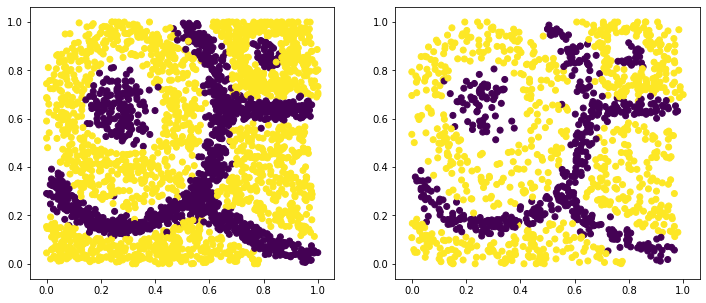

In [11]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.scatter(x_train[_X], x_train[_Y], c=y_train)

fig.add_subplot(122)

plt.scatter(x_valid[_X], x_valid[_Y], c=y_valid)
plt.show()

In [12]:
train_ds = TD(T(x_train), T(y_train))
train_dl = DL(train_ds, batch_size=64, shuffle=True)

valid_ds = TD(T(x_valid), T(y_valid))
valid_dl = DL(valid_ds, batch_size=64, shuffle=False)

In [300]:
class NN(nn.Module):
    
    def __init__(self, num_hyperplanes):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(2, num_hyperplanes),
            nn.BatchNorm1d(num_hyperplanes),  # maintain health gradient flow
            nn.Sigmoid(),
            nn.Linear(num_hyperplanes, 1),  
            nn.BatchNorm1d(1),  # maintain health gradient flow
            nn.Sigmoid(),
        )
    
    def forward(self, xb):
        xb = self.main(xb)
        return xb.view(-1)

In [301]:
def get_model(num_hyperplanes):
    nn = NN(num_hyperplanes)
    return nn, optim.Adam(nn.parameters(), lr=10)

## Train a neural network

In [302]:
import sys
sys.path.append('../modules_for_nn_training')
from learner import Learner
from callbacks import CallbackHandler
from utility_callbacks import LossCallback, AccuracyCallback
from trainer import Trainer

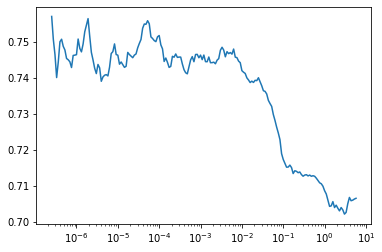

In [304]:
model, opt = get_model(150)
loss = nn.BCELoss()
learn = Learner(train_dl, valid_dl, model, loss, opt)

loss_cb = LossCallback()
acc_cb = AccuracyCallback()
cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

lrs, losses = trainer.find_lr(beta=0.98)

plt.plot(lrs[10:-5], losses[10:-5])
# plt.scatter(lrs, losses)
plt.xscale('log')
plt.show()

In [305]:
for param_group in trainer.learn.opt.param_groups:
    param_group['lr'] = 0.06

In [306]:
trainer.train(500)

## Plot loss and accuracy over epoch

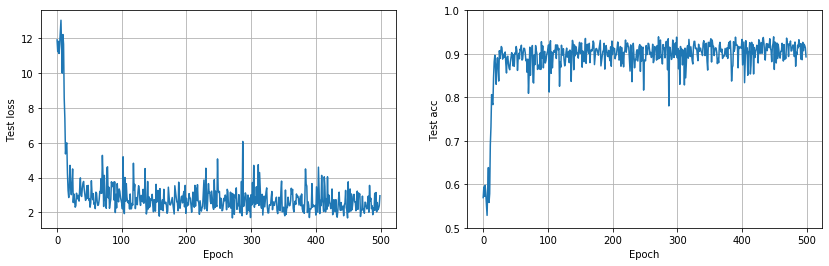

In [307]:
fig = plt.figure(figsize=(14, 4))

ax = fig.add_subplot(121)
loss_cb.plot()

fig.add_subplot(122)
acc_cb.plot()

plt.show() 

## Visualize decision boundary

In [308]:
xs = np.linspace(start=0, stop=1, num=100)
ys = xs.copy()
xxs, yys = np.meshgrid(xs, ys)
xxs, yys = xxs.flatten(), yys.flatten()
xxs.shape, yys.shape

((10000,), (10000,))

In [309]:
grid = np.hstack([xxs.reshape(-1, 1), yys.reshape(-1, 1)])
grid = T(grid)
grid.size()

torch.Size([10000, 2])

In [310]:
grid_values = model(grid.float()).detach().numpy()
grid_values.shape

(10000,)

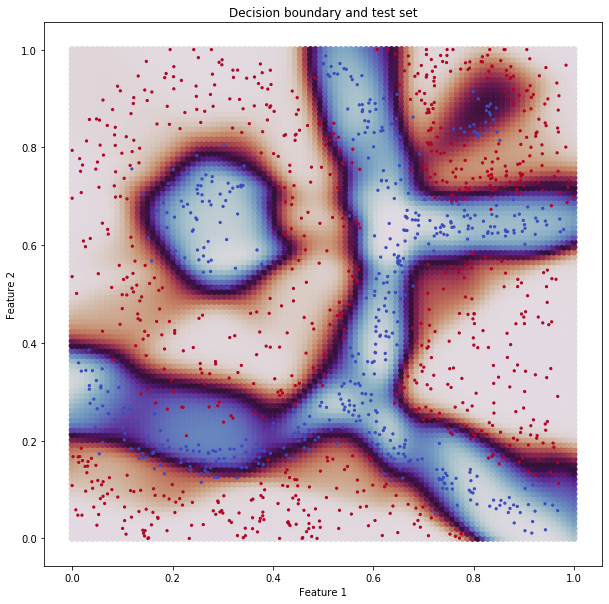

In [311]:
plt.figure(figsize=(10, 10))
plt.scatter(grid[_X], grid[_Y], c=grid_values, cmap='twilight')
plt.scatter(x_valid[_X], x_valid[_Y], c=y_valid, s=5, cmap='coolwarm')
plt.title('Decision boundary and test set')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2')
plt.show()

## Deconstruct decision boundary

In [26]:
l1_weights, l1_biases, l2_weights, l2_biases = list(model.parameters())
l1_weights, l1_biases, l2_weights, l2_biases = map(lambda var : var.detach().numpy(), [
    l1_weights, l1_biases, l2_weights, l2_biases
])

In [27]:
X = xxs.reshape(100, 100)
Y = yys.reshape(100, 100)

In [28]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [29]:
def get_activations(neuron_index):
    w1, w2 = l1_weights[neuron_index-1]
    w0 = l1_biases[neuron_index-1]
    Z = sigmoid(w1 * X + w2 * Y + w0)
    return Z

In [30]:
Z1 = get_activations(1)
Z2 = get_activations(2)
Z3 = get_activations(3)

In [31]:
w1, w2, w3 = l2_weights[0]
w0 = l2_biases

ValueError: too many values to unpack (expected 3)

In [32]:
def plot_wireframe(X, Y, Z, title, ylabel, ax):
    
    ax.plot_wireframe(X, Y, Z, alpha=0.2)
    ax.contourf(X, Y, Z, zdir='z', offset=Z.min(), cmap=cm.twilight)
    
    ax.scatter(x_valid[_X], x_valid[_Y], zs=Z.min(), s=1, c=y_valid, cmap='viridis')
    
    ax.set_xlabel('Feature 1'); ax.set_ylabel('Feature 2'); ax.set_zlabel(ylabel)
    ax.set_title(title)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(Z.min(), Z.max())

NameError: name 'w0' is not defined

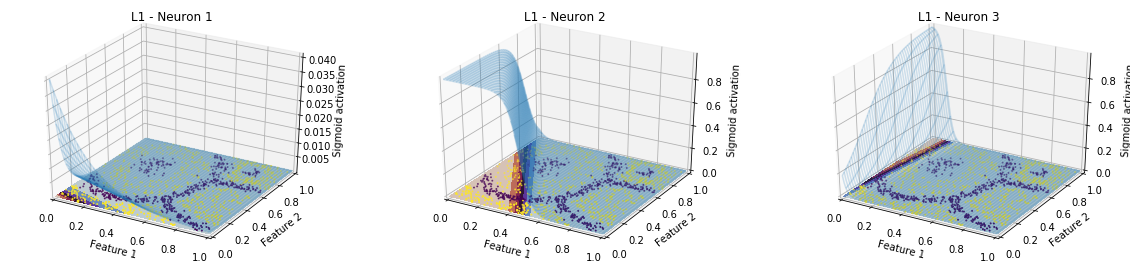

In [33]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(231, projection='3d')
plot_wireframe(X, Y, Z1, 'L1 - Neuron 1', 'Sigmoid activation', ax)

ax = fig.add_subplot(232, projection='3d')
plot_wireframe(X, Y, Z2, 'L1 - Neuron 2', 'Sigmoid activation', ax)

ax = fig.add_subplot(233, projection='3d')
plot_wireframe(X, Y, Z3, 'L1 - Neuron 3', 'Sigmoid activation', ax)

l2_linear_combination = w0 + w1 * Z1 + w2 * Z2 + w3 * Z3

ax = fig.add_subplot(234, projection='3d')
plot_wireframe(X, Y, l2_linear_combination, 'L2 - Neuron 1', 'Linear combination', ax)

ax = fig.add_subplot(235, projection='3d')
plot_wireframe(X, Y, sigmoid(l2_linear_combination), 'L2 - Neuron 1', 'Sigmoid activation', ax)

fig.add_subplot(236)
plt.scatter(grid[_X], grid[_Y], c=grid_values, cmap='twilight')
plt.scatter(x_valid[_X], x_valid[_Y], c=y_valid, s=5, cmap='viridis')
plt.title('Decision boundary and test set')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2')

plt.show()

- Row 2, column 2: an example of a local basis function